# 05 – Unsupervised Learning (Clustering)

K‑Means (elbow) and Hierarchical (dendrogram); compare clusters with labels.


Shape after cleaning: (303, 14)
Target distribution:
 target
0    164
1    139
Name: count, dtype: int64


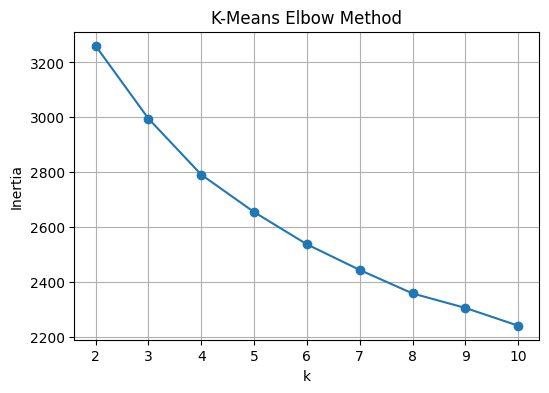

Adjusted Rand Index vs true labels: 0.4381


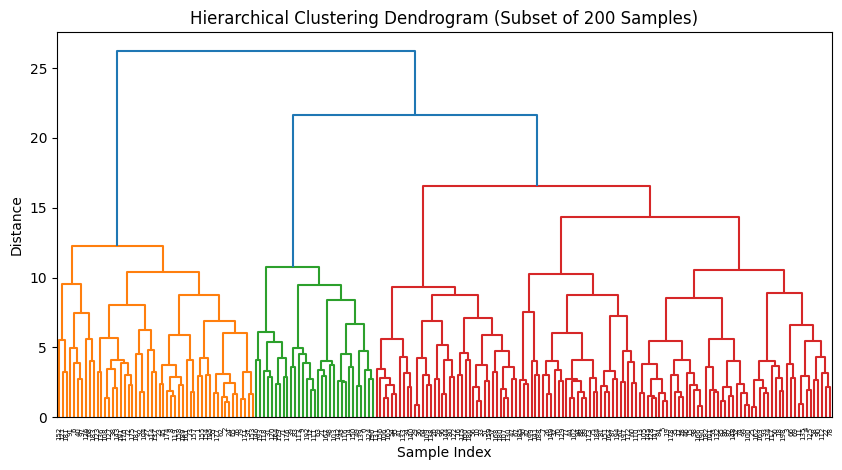

In [1]:
# --- Imports ---
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, scipy.cluster.hierarchy as sch
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# --- 1. Load and clean .data file ---
DATA_PATH = os.path.join("..", "data", "heart_disease.data")  # adjust if needed
df = pd.read_csv(DATA_PATH, header=None)

# Assign column names based on UCI dataset
df.columns = [
    "age","sex","cp","trestbps","chol","fbs","restecg",
    "thalach","exang","oldpeak","slope","ca","thal","num"
]

# Replace '?' with NaN and convert to numeric
df = df.replace('?', np.nan)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where target is missing and create binary target
df = df.dropna(subset=['num'])
df['target'] = (df['num'] > 0).astype(int)
df = df.drop(columns=['num'])

print("Shape after cleaning:", df.shape)
print("Target distribution:\n", df['target'].value_counts())

# --- 2. Split features and target ---
X = df.drop(columns=['target'])
y = df['target']

num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = [c for c in X.columns if c not in num_features]

# --- 3. Preprocessing pipeline ---
prep = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_features),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_features)
])

# Transform features
X_proc = prep.fit_transform(X)
X_proc = X_proc.toarray() if hasattr(X_proc, "toarray") else X_proc

# --- 4. Elbow method to choose k ---
distortions = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_proc)
    distortions.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(K_range), distortions, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("K-Means Elbow Method")
plt.grid(True)
plt.show()

# --- 5. Fit K-Means with k=2 ---
k = 2
km = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = km.fit_predict(X_proc)

# Compare clusters with true labels using ARI
ari = adjusted_rand_score(y, clusters)
print(f"Adjusted Rand Index vs true labels: {ari:.4f}")

# --- 6. Hierarchical clustering dendrogram ---
# Use a subset to avoid clutter
subset = X_proc[:200]
plt.figure(figsize=(10,5))
dend = sch.dendrogram(sch.linkage(subset, method='ward'))
plt.title("Hierarchical Clustering Dendrogram (Subset of 200 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()
